Farutin Vadim

Homework02

In [7]:
import numpy as np
import operator
import csv

Reading datasets.

In [4]:
def read_spam():
    D = []
    
    with open('./Datasets/spam.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [5]:
def read_cancer():
    D = []
    
    with open('./Datasets/cancer.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            D.append(np.array([np.array(list(map(float, row[1:]))), row[0]]))

    return np.array(D)

In [6]:
def read_blobs():
    D = []
    
    with open('./Datasets/blobs.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array(row))

    return np.array(D)

In [7]:
def read_blobs2():
    D = []
    
    with open('./Datasets/blobs2.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [8]:
def extract_labels(D):
    X = np.array([row[0] for row in D])
    Y = np.array([row[1] for row in D])
    
    return X, Y

In [9]:
from sklearn.model_selection import train_test_split

def split_dataset(D, train_size):
    X, Y = extract_labels(D)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=1 - train_size)
    D_train = np.array([[x_row, y_row] for x_row, y_row in zip(X_train, Y_train)])
    D_test = np.array([[x_row, y_row] for x_row, y_row in zip(X_test, Y_test)])
    
    return D_train, D_test

VC-theory


1. (2 points) Identify breakpoints, VC-dimensions and growth functions of following hypotheses:

a) h(x) = +1 if x_i > a 

b) h(x) = +1 if a < x_i < b

a) Рассмотрим произвольные N точек на прямой, число a делит их на две группы, всего N + 1 способов (левее всех точек, между ними, правее). Значит m(N) = N + 1.

k + 1 = 2^k -- для k = 1 верно, для k = 2 нет, значит breakpoint = 2, d = 1.

b) Произвольные N точек на прямой разбивают ее на N + 1 частей, выбор промежутка для границы a оставляет выбор для b из N + 1, N, ... 1 промежутков -- при попадании a в первый, второй, ... N + 1-ый соответсвтенно. Но варианты выбора, при которых a и b попали в один промежуток, соответствуют одной и той же дихотомии (всем точкам сопоставляется -1), значит из общего числа варинатов нужно вычесть эти N повторов. Итого, m(N) = (N + 1)(N + 2) / 2 - N = (N^2 + N + 2) / 2.

(k^2 + k + 2) / 2 = 2^k -- для k = 2 верно, для k = 3 нет, значит breakpoint = 3, d = 2.

Perceptron

Dataset: blobs2.csv.

2. (4 points) Implement the pocket perceptron algorithm. Train-test split the dataset (80%/20%). Train the algorithm on train points and find the best performing line on test points. Find the best perceptron. Draw dataset points and the resulting line.

In [10]:
def perceptron_clusters(X, h):
    return np.array([h(x) for x in X])

In [11]:
def perceptron_error(X, Y, h):
    return np.mean(perceptron_clusters(X, h) != Y)

In [12]:
from sklearn.preprocessing import PolynomialFeatures

def pocket_perceptron(D, degree, iter_num):
    D_train, D_test = split_dataset(D, 0.8)
    X_train, Y_train = extract_labels(D_train)
    X_train_extended = PolynomialFeatures(degree=degree).fit_transform(X_train)
    X_test, Y_test = extract_labels(D_test)
    X_test_extended = PolynomialFeatures(degree=degree).fit_transform(X_test)

    w = np.random.rand(len(X_train_extended[0]))
    def h(w):
        return lambda x: 0 if np.sign(np.dot(w, x)) < 0 else 1
    
    best_w = w
    best_error = perceptron_error(X_test_extended, Y_test, h(w))
    
    for i in range(iter_num):
        for x, y in zip(X_train_extended, Y_train):
            if h(w)(x) != y:
                w = w + (2 * y - 1) * x
                error = perceptron_error(X_test_extended, Y_test, h(w))

                if error < best_error:
                    best_w = w
                    best_error = error
    
    return h(best_w)

In [13]:
import matplotlib.pyplot as plt

# Most part of this code is taken from sklearn example:
# https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
def plot_perceptron(D, h, degree):
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        return xx, yy


    def plot_contours(ax, h, xx, yy, **params):
        Z = perceptron_clusters(PolynomialFeatures(degree=degree).fit_transform(np.c_[xx.ravel(), yy.ravel()]),
                                h)
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    X, Y = extract_labels(D)
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    fig, ax = plt.subplots()
    
    plot_contours(ax, h, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    plt.show()

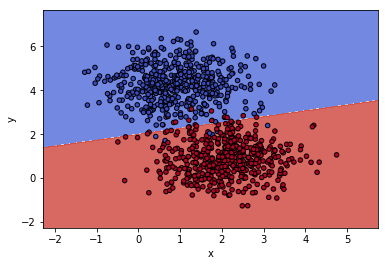

In [14]:
D = read_blobs2()
degree = 1
iter_num = 100
h = pocket_perceptron(D, degree, iter_num)
plot_perceptron(D, h, degree)

3. (4 points) Add second-degree polynomial features to the dataset (x_1^2, x_2^2, x_1x_2), find the best perceptron hyperplane. Draw a projection of the hyperplane to the original two-dimensional space. Repeat for third- and fourth-degree polynomial features.


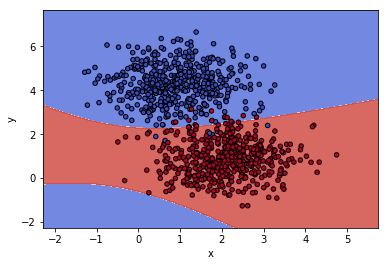

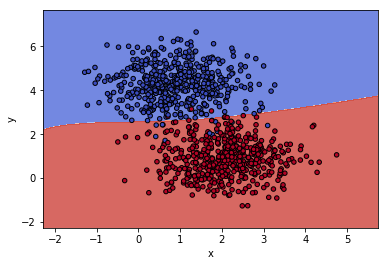

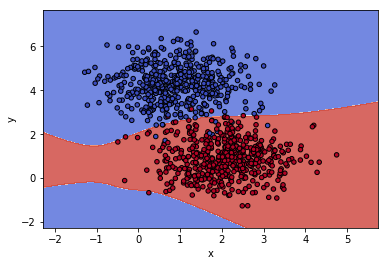

In [15]:
D = read_blobs2()
iter_num = 100

for degree in range(2, 5):
    h = pocket_perceptron(D, degree, iter_num)
    plot_perceptron(D, h, degree)

Logistic regression

Datasets: cancer.csv, spam.csv.

4. (4 points) Implement the logistic regression algorithm. Train it via the stochastic gradient descent and output draw the accuracy/iteration curve.

In [12]:
def logistic_regression_clusters(X, h):
    return np.array([h(x) for x in X])

In [13]:
def logistic_regression_error(X, Y, h):
    return np.mean(logistic_regression_clusters(X, h) != Y)

In [121]:
from sklearn.preprocessing import MinMaxScaler
    
def logistic_regression(D, epoch_num, batch_size):
    X, Y = extract_labels(D)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    Y_renamed = np.zeros(len(Y))
    Y_renamed[Y == Y[0]] = -1
    Y_renamed[Y != Y[0]] = 1
    
    w = np.random.rand(len(X[0]))
    accuracies = np.empty(epoch_num)
    
    def sigma(s):
        return 1 / (1 + np.exp(-s))
    
    def sgd(w):
        return lambda x, y: y / (1 + np.exp(y * np.dot(w, x))) * x
    
    def h(w):
        return lambda x: -1 if sigma(np.dot(w, x)) < 0.5 else 1
    
    batches = [range(batch_size * i, 
                     min(batch_size * (i + 1), len(D))) 
               for i in range((len(D) + batch_size - 1) // batch_size)]
    
    for i in range(epoch_num):
        for batch in batches:
            batch_sum = 0
            
            for j in batch:
                batch_sum += sgd(w)(X[j], Y_renamed[j])
            
            w = w - (- batch_sum / len(batch))
        
        accuracies[i] = 1.0 - logistic_regression_error(X, Y_renamed, h(w))
    
    return accuracies

In [122]:
import matplotlib.pyplot as plt

def plot_logistic_regression_curve(accuracies):
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.plot(list(range(len(accuracies))), accuracies)
    plt.show()

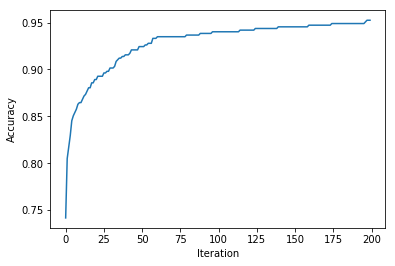

In [123]:
D = read_cancer()
epoch_num = 200
batch_size = 32
accuracies = logistic_regression(D, epoch_num, batch_size)
plot_logistic_regression_curve(accuracies)

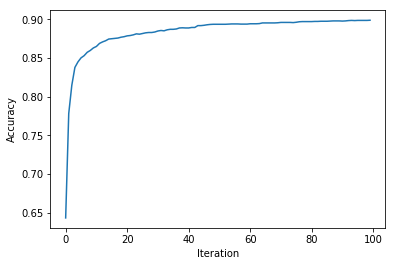

In [124]:
D = read_spam()
epoch_num = 100
batch_size = 32
accuracies = logistic_regression(D, epoch_num, batch_size)
plot_logistic_regression_curve(accuracies)

Neural networks

Datasets: mnist.csv, notMNIST.tar.gz

5. (2 points) Prepare the datasets so that every point is represented by a two-dimensional tensor.


In [12]:
import torch
from torch.utils.data import Dataset
import os
from skimage import io
from skimage.transform import rotate
from sklearn.model_selection import train_test_split

In [13]:
class mnistDataset(Dataset):
    def __init__(self, X=None, Y=None):
        image_shape = (1, 28, 28)
        
        if X is None:
            X = []
            Y = []

            with open('./Datasets/mnist.csv', newline='') as csv_file:
                dataset_reader = csv.reader(csv_file, delimiter=',')
                next(dataset_reader)
                for row in dataset_reader:
                    original_array = np.array(list(map(int, row[1:])))
                    reshaped_array = np.reshape(original_array, image_shape)
                    X.append(reshaped_array)
                    Y.append(int(row[0]))
            
            X = 2 * np.array(X) / 255 - 1

        self.X = np.array(X)
        self.Y = np.array(Y)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.X[index]), torch.LongTensor(self.Y)[index]
    
    def split(self, train_size):
        X_train = []
        X_test = []
        Y_train = []
        Y_test = []
        
        for y in np.unique(self.Y):
            X_train_cur, X_test_cur, Y_train_cur, Y_test_cur = train_test_split(
                self.X[self.Y == y], self.Y[self.Y == y], train_size=train_size, test_size=1-train_size)
            X_train.extend(X_train_cur)
            X_test.extend(X_test_cur)
            Y_train.extend(Y_train_cur)
            Y_test.extend(Y_test_cur)
            
        return mnistDataset(X_train, Y_train), mnistDataset(X_test, Y_test)

6. (4 points) Create a neural network that consists out of three convolutional layers with 8 3x3 filters each and two fully-connected layers with 64 neurons each. Train the network on the mnist dataset with three different types of activation functions (sigmoid, tanh, ReLU).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
class Net(nn.Module):
    def __init__(self, act_func):
        super(Net, self).__init__()
        self.act_func = act_func
        self.image_size = 28 * 28
        
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        
        self.fc1 = nn.Linear(8 * self.image_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 8 * self.image_size)
        x = self.act_func(self.fc1(x))
        x = self.act_func(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def train_net(net, dataset, epoch_num):
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    dev = torch.device("cpu")
    net.to(dev)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    for epoch in range(epoch_num):
        for data in loader:
            X, Y = data
            X, Y = X.to(dev), Y.to(dev)
            optimizer.zero_grad()
            outputs = net(X)
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()

In [5]:
def test_net(net, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    score = 0
    
    for data in loader:
        X, Y = data
        with torch.no_grad():
            outputs = net(X)
        _, Y_predict = torch.max(outputs, 1)
        score += (Y_predict == Y).sum().item()
    
    score /= len(dataset)
    return score

In [14]:
dataset = mnistDataset()
train, test = dataset.split(0.8)

In [85]:
net = Net(torch.sigmoid)
epoch_num = 10
train_net(net, train, epoch_num)
score = test_net(net, test)
print(score)

0.8831752371442836


In [15]:
net = Net(torch.tanh)
epoch_num = 20
train_net(net, train, epoch_num)
score = test_net(net, test)
print(score)

0.9470793809286071


In [87]:
net = Net(torch.relu)
epoch_num = 20
train_net(net, train, epoch_num)
score = test_net(net, test)
print(score)

0.9525711432850724


7. (3 points) Reach an accuracy of 90% on the notMNIST test dataset. All techniques are permitted.

In [172]:
class NotMnistNet(nn.Module):
    def __init__(self, act_func):
        super(NotMnistNet, self).__init__()
        self.act_func = act_func
        self.image_size = 28 * 28
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.max_pool = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(16 * self.image_size // 4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)
        x = nn.Dropout(0.25)(x)

        x = torch.relu(self.conv3(x))
        x = nn.Dropout(0.25)(x)
        
        x = x.view(-1, 16 * self.image_size // 4)
        x = self.act_func(self.fc1(x))
        x = nn.Dropout(0.5)(x)
        x = self.fc3(x)
        return x

In [149]:
def train_net(net, dataset, epoch_num):
#     dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    dev = torch.device("cpu")
    net.to(dev)
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=0.01)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    train, validate = dataset.split(0.8)
    train.augment()
    loader = DataLoader(train, batch_size=32, shuffle=True)
    parameters = []
    max_score = 0
    
    for epoch in range(epoch_num):
        for data in loader:
            X, Y = data
            X, Y = X.to(dev), Y.to(dev)
            optimizer.zero_grad()
            outputs = net(X)
            loss = criterion(outputs, Y)
            loss.backward()
            optimizer.step()
            
        score = test_net(net, validate)
        print('epoch %d: validation score %f' % (epoch, score))
        if score > max_score:
            parameters = [param.data.clone() for param in net.parameters()]
            max_score = score
    
    for i, param in enumerate(net.parameters()):
        param.data = parameters[i]

In [150]:
def test_net(net, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    score = 0
    
    for data in loader:
        X, Y = data
        with torch.no_grad():
            outputs = net(X)
        _, Y_predict = torch.max(outputs, 1)
        score += (Y_predict == Y).sum().item()
    
    score /= len(dataset)
    return score

In [158]:
class NotMnistDataset(Dataset):
    def __init__(self, X=None, Y=None):
        root_dir = './Datasets/notMNIST_small'

        if X is None:
#             X_paths = []
            X = []
            Y = []
            
            for subdir in os.listdir(root_dir):
                for root, _, files in os.walk(os.path.join(root_dir, subdir)):
                    files = np.array(files)
                    files = files[files != 'Thumbs.db']
#                     X_paths.extend([os.path.join(root, file) for file in files])
                    X.extend([io.imread(os.path.join(root, file)) for file in files])
                    Y.extend([int(ord(subdir[0]) - ord('A')) for _ in files])

            X = 2 * np.array(X) / 255 - 1
    
#         self.X_paths = np.array(X_paths)
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
                    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
#         x = io.imread(self.X_paths[index])
#         return torch.FloatTensor(x)[None, :, :], torch.LongTensor(self.Y)[index]
        return self.X[index][None, :, :], self.Y[index]

    def augment(self):
        X_numpy = self.X.numpy()
        Y_numpy = self.Y.numpy()
        
        X_numpy = np.concatenate((X_numpy, list(map(lambda x: rotate(x, 10), X_numpy))), axis=0)
        Y_numpy = np.concatenate((Y_numpy, Y_numpy), axis=0)
        X_numpy = np.concatenate((X_numpy, list(map(lambda x: rotate(x, -10), X_numpy))), axis=0)
        Y_numpy = np.concatenate((Y_numpy, Y_numpy), axis=0)
        
        self.X = torch.FloatTensor(X_numpy)
        self.Y = torch.LongTensor(Y_numpy)
        
    def split(self, train_size):
        X_paths_train = []
        X_paths_test = []
        Y_train = []
        Y_test = []
        
        X_numpy = self.X.numpy()
        Y_numpy = self.Y.numpy()
        
        for y in np.unique(Y_numpy):
            X = (X_numpy[Y_numpy == y])
            Y = (Y_numpy[Y_numpy == y])
            X_train_cur, X_test_cur, Y_train_cur, Y_test_cur = train_test_split(
                X, Y, train_size=train_size, test_size=1-train_size)
            X_paths_train.extend(X_train_cur)
            X_paths_test.extend(X_test_cur)
            Y_train.extend(Y_train_cur)
            Y_test.extend(Y_test_cur)
            
        return NotMnistDataset(X_paths_train, Y_train), NotMnistDataset(X_paths_test, Y_test)

In [152]:
notMnistDataset = NotMnistDataset()
notMnistTrain, notMnistTest = notMnistDataset.split(0.8)

In [173]:
notMnistNet = NotMnistNet(torch.relu)

In [174]:
epoch_num = 20
train_net(notMnistNet, notMnistTrain, epoch_num)
score = test_net(notMnistNet, notMnistTest)
print(score)

epoch 0: validation score 0.888667
epoch 1: validation score 0.906333
epoch 2: validation score 0.913333
epoch 3: validation score 0.917333
epoch 4: validation score 0.916000
epoch 5: validation score 0.926000
epoch 6: validation score 0.923667
epoch 7: validation score 0.919667
epoch 8: validation score 0.919000
epoch 9: validation score 0.917667
epoch 10: validation score 0.922667
epoch 11: validation score 0.926333
epoch 12: validation score 0.920333
epoch 13: validation score 0.928000
epoch 14: validation score 0.925000
epoch 15: validation score 0.932667
epoch 16: validation score 0.923667
epoch 17: validation score 0.928333
epoch 18: validation score 0.928667
epoch 19: validation score 0.922000
0.9290666666666667


8. (3 points) Reach an accuracy of 95% on the notMNIST test dataset. All techniques are permitted.